In [1]:
import os
import pandas as pd
import seaborn as sns
import requests
import json
from googleapiclient.discovery import build
from pandas import json_normalize

from dotenv import load_dotenv
load_dotenv()

True

## Find Channel IDs and Put Them Into a List

In [2]:
#Just a bit of setup for the project
api_key = os.environ.get('YOUTUBE_INSIGHTS_API_KEY')

channel_ids = ['UCAiLfjNXkNv24uhpzUgPa6A', #MrBeast Philanthropy
               'UCUaT_39o1x6qWjz7K2pWcgw', #Beast Reacts
               'UCgoFStVyEsm8tBZP5NC-aBQ', #MrBeast
               'UC4-79UOlP48-QNGgCko5p2g', #MrBeast 2
               'UCIPPMRA040LQr5QPyJEbmXA'  #MrBeast Gaming
               ]
         

channel_id = 'UCgoFStVyEsm8tBZP5NC-aBQ'
youtube = build('youtube', 'v3', developerKey=api_key)

In [3]:
# #MrBeast custom URL was returning values that weren't consistent with statistics on the channel page
# #Here I am attempting to extract the channel ID

# url = "https://www.googleapis.com/youtube/v3/channels"
# params = {
#     'part': 'snippet',
#     'forUsername': 'MrBeast',
#     'key': api_key
# }

# response = requests.get(url, params=params)


In [4]:

# Check the response status code to see if the request was successful
# if response.status_code == 200:
#     # If the request was successful, check if the 'items' key is in the response
#     if 'items' in response.json():
#         channel_id = response.json()['items'][0]['id']
#         print(channel_id)
#     else:
#         # If the 'items' key is not in the response, the channel may not have been found
#         print("The channel was not found.")
# else:
#     # If the request was unsuccessful, you may need to check the API key or URL
#     print("An error occurred while trying to retrieve the channel ID.")
 
##Channel ID still yielded values inconsistent with the channel page. I'll just have to work with what I've got for now

## Get Channel Statistics:

In [5]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, Statistics',
        id=','.join(channel_ids))
    response=request.execute()

    for item in response['items']:
        data = dict(Channel_Name = item['snippet']['title'],
                Subscribers = item['statistics']['subscriberCount'],
                Views = item['statistics']['viewCount'],
                Total_videos = item['statistics']['videoCount'],
                playlist_id = item['contentDetails']['relatedPlaylists']['uploads'])
        
        all_data.append(data)
    
    return all_data

In [6]:
channel_statistics = get_channel_stats(youtube, channel_ids)
# channel_statistics

In [7]:
channel_data = pd.DataFrame(channel_statistics)
# channel_data

## Quick Visual Check of Channel Stats:

In [8]:
channel_data['Channel_Name']= channel_data['Channel_Name'].astype(str)
channel_data['Subscribers']= channel_data['Subscribers'].astype('int64')
channel_data['Views']= channel_data['Views'].astype('int64')
channel_data['Total_videos']= channel_data['Total_videos'].astype('int64')

In [9]:
channel_data.sort_values(by='Subscribers', ascending=False, inplace=True)
channel_data.dtypes

Channel_Name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

Text(0.5, 0, 'Channel')

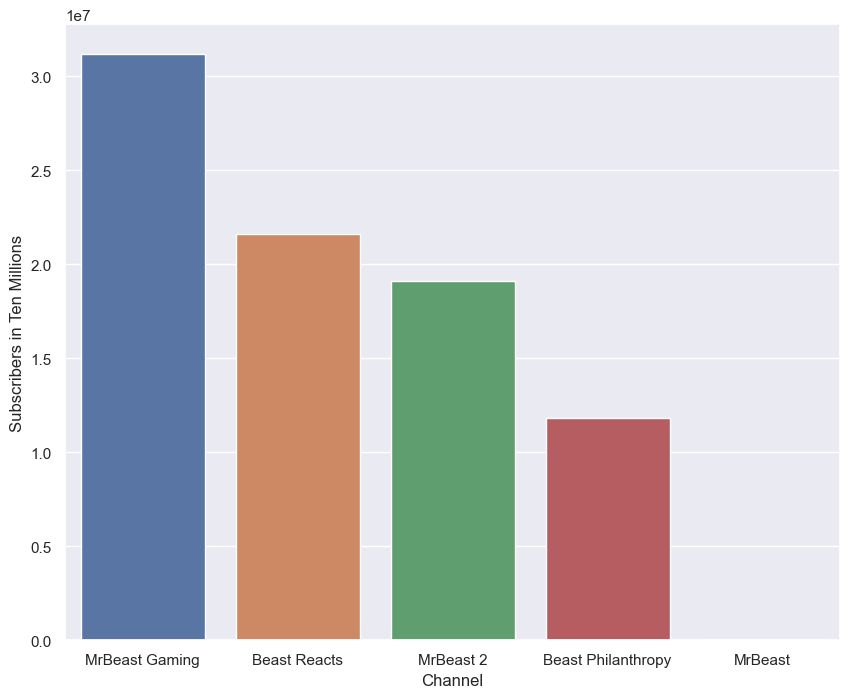

In [10]:
sns.set(rc={'figure.figsize':(10,8)})
channel_data.sort_values(by='Subscribers', ascending=False, inplace=False)
ax = sns.barplot(x='Channel_Name', y='Subscribers', data=channel_data)
ax.set_ylabel("Subscribers in Ten Millions")
ax.set_xlabel("Channel")

Text(0.5, 0, 'Channel')

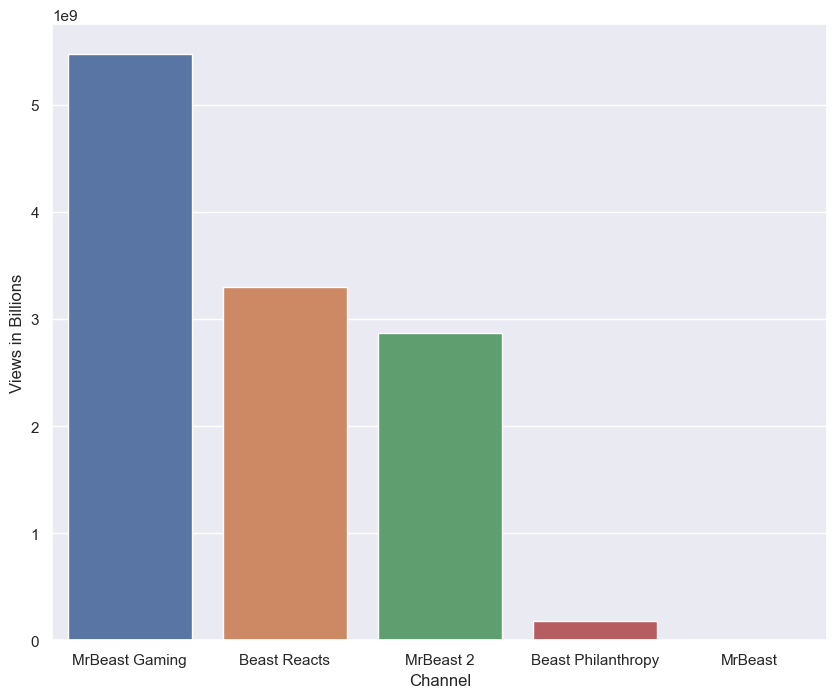

In [11]:
ax = sns.barplot(x='Channel_Name', y='Views', data=channel_data)
ax.set_ylabel("Views in Billions")
ax.set_xlabel("Channel")

Text(0.5, 0, 'Channel')

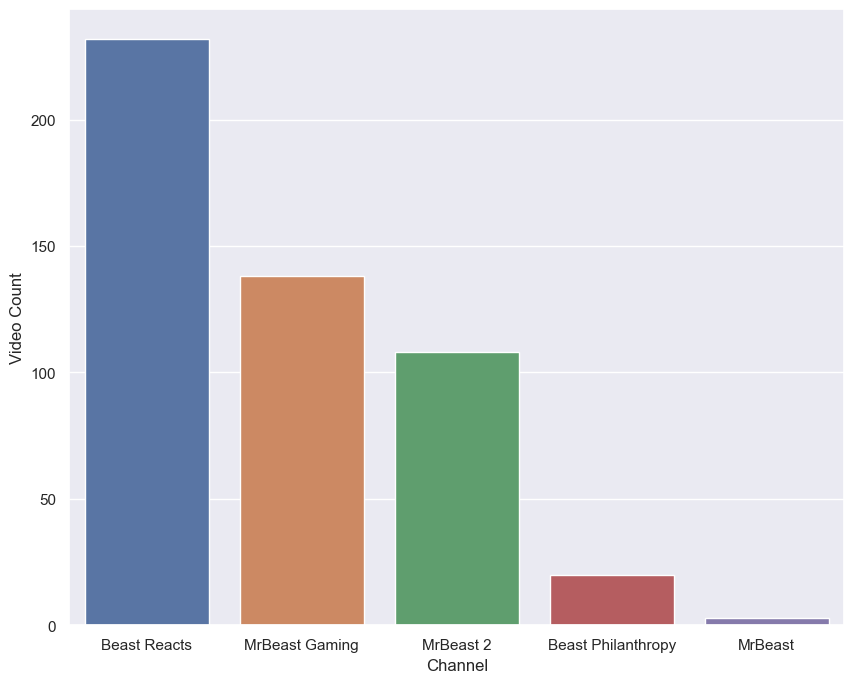

In [12]:
sorted_data = channel_data.sort_values(by='Total_videos', ascending=False)
ax = sns.barplot(x='Channel_Name', y='Total_videos', data=sorted_data, order=sorted_data['Channel_Name'])
ax.set_ylabel("Video Count")
ax.set_xlabel("Channel")

In [13]:
channel_data

,Channel_Name,Subscribers,Views,Total_videos,playlist_id
3,MrBeast Gaming,31200000,5479645123,138,UUIPPMRA040LQr5QPyJEbmXA
1,Beast Reacts,21600000,3299090706,232,UUUaT_39o1x6qWjz7K2pWcgw
2,MrBeast 2,19100000,2868466893,108,UU4-79UOlP48-QNGgCko5p2g
0,Beast Philanthropy,11800000,178446314,20,UUAiLfjNXkNv24uhpzUgPa6A
4,MrBeast,1630,67343,3,UUgoFStVyEsm8tBZP5NC-aBQ


## Finding Video IDs:

In [14]:
playlist_id = channel_data.loc[channel_data['Channel_Name'] == 'MrBeast Gaming', 'playlist_id'].iloc[0]

In [15]:
playlist_id

'UUIPPMRA040LQr5QPyJEbmXA'

In [16]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    next_page_token = None
    
    while True:
        request = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token)       
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        if 'nextPageToken' not in response:
            break
        else:
            next_page_token = response['nextPageToken']
    
    return video_ids

In [17]:
video_ids_by_channel = {}
for channel_name in channel_data['Channel_Name']:
    playlist_id = channel_data.loc[channel_data['Channel_Name'] == channel_name, 'playlist_id'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    video_ids_by_channel[channel_name] = video_ids

In [18]:
# video_ids_by_channel

## Get Video Details:

In [19]:
def get_video_details(youtube, video_ids):
    all_video_stats = []
    
    for video in video_ids:
        request = youtube.videos().list(
                    part='snippet, contentDetails, statistics',
                    id=video)
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'],
                               CategoryId = video['snippet']['categoryId'],
                               VideoId = video['id'],
                               Channel = video['snippet']['channelTitle']
                               )
            all_video_stats.append(video_stats)
    
    return all_video_stats

In [20]:
all_video_stats_by_channel = {}
for channel_name in video_ids_by_channel.keys():
    video_ids = video_ids_by_channel[channel_name]
    all_video_stats = get_video_details(youtube, video_ids)
    all_video_stats_by_channel[channel_name] = all_video_stats

json_all_video_stats_by_channel = json.dumps(all_video_stats_by_channel)

## Prepare Data For Export:

In [21]:
# all_video_stats_by_channel
#json_all_video_stats_by_channel
# channel_data

In [22]:
beastdata_stats = []
for channel_name in video_ids_by_channel.keys():
    video_ids = video_ids_by_channel[channel_name]
    all_video_stats = get_video_details(youtube, video_ids)
    beastdata_stats.append(all_video_stats)

In [23]:
beastdata = pd.DataFrame(beastdata_stats)
beastdata = beastdata.transpose()
channel_names = ['MrBeast Gaming','Beast Reacts', 'MrBeast 2', 'Beast Philanthropy', 'MrBeast']
beastdata.columns = channel_names
# beastdata

## Export Data As CSV

In [24]:
# Export Data to CSV
beastdata.to_csv('Data/BeastData.csv')

## Export Data As JSON 

In [26]:
with open("Data/JSON/BeastData.json", "w") as file:
    json.dump(json_all_video_stats_by_channel, file)

MrBeast = pd.json_normalize(json.loads(json_all_video_stats_by_channel), 'MrBeast')
MrBeast = MrBeast[['Title', 'Published_date', 'Views', 'Likes', 'Comments', 'CategoryId', 'VideoId', 'Channel']]
with open("Data/JSON/MrBeast.json", "w") as file:
    json.dump(MrBeast.to_json(), file)

MrBeast_2 = pd.json_normalize(json.loads(json_all_video_stats_by_channel), 'MrBeast 2')
MrBeast_2 = MrBeast_2[['Title', 'Published_date', 'Views', 'Likes', 'Comments', 'CategoryId', 'VideoId', 'Channel']]
with open("Data/JSON/MrBeast_2.json", "w") as file:
    json.dump(MrBeast_2.to_json(), file)

MrBeast_Gaming = pd.json_normalize(json.loads(json_all_video_stats_by_channel), 'MrBeast Gaming')
MrBeast_Gaming = MrBeast_Gaming[['Title', 'Published_date', 'Views', 'Likes', 'Comments', 'CategoryId', 'VideoId', 'Channel']]
with open("Data/JSON/MrBeastGaming.json", "w") as file:
    json.dump(MrBeast_Gaming.to_json(), file)

Beast_Philanthropy = pd.json_normalize(json.loads(json_all_video_stats_by_channel), 'Beast Philanthropy')
Beast_Philanthropy = Beast_Philanthropy[['Title', 'Published_date', 'Views', 'Likes', 'Comments', 'CategoryId', 'VideoId', 'Channel']]
with open("Data/JSON/BeastPhilanthropy.json", "w") as file:
    json.dump(Beast_Philanthropy.to_json(), file)

BeastReacts = pd.json_normalize(json.loads(json_all_video_stats_by_channel), 'Beast Reacts')
BeastReacts = BeastReacts[['Title', 'Published_date', 'Views', 'Likes', 'Comments', 'CategoryId', 'VideoId', 'Channel']]
with open("Data/JSON/BeastReacts.json", "w") as file:
    json.dump(BeastReacts.to_json(), file)